# Solar Calculations

In [27]:
%matplotlib widget
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import print_code, solar_angles_to_vector, solar_position, add_solar_axis
# from utils import print_code, solar_angles_to_vector, solar_position, add_solar_axis
import numpy as np
from IPython.core.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from datetime import datetime

In [28]:
HTML(print_code(solar_angles_to_vector))

In [29]:
vec = solar_angles_to_vector(135, 179)
print(vec)

[-0.08814742  0.99359368  0.07072217]


In [30]:
HTML(print_code(solar_position))

In [31]:
date = datetime(2023, 3, 15, 2, 0, 0)
lat = 55.2 # Copenhagen
lng = 12.575782667531543

az, alt = solar_position(date, lat, lng)

print(f"Azimuth: {np.degrees(az):.2f} degrees")
print(f"Altitude: {np.degrees(alt):.2f} degrees")

Azimuth: 46.92 degrees
Altitude: -28.09 degrees


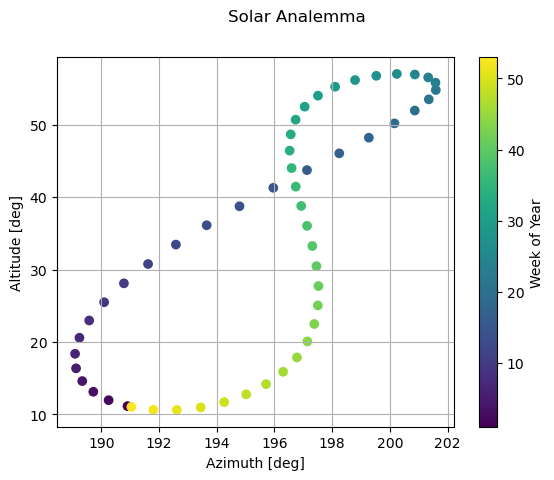

In [32]:
start_date = '2023-01-01 12:00:00'
end_date = '2023-12-31 12:00:00'
date_range = pd.date_range(start=start_date, end=end_date, freq="W")
sun_pos = np.empty([len(date_range), 2])
fig, ax = plt.subplots()
fig.suptitle("Solar Analemma")
for i, date in enumerate(date_range):
    az, alt = solar_position(date, lat, lng)
    sun_pos[i,:] = az, alt

scat = ax.scatter(*np.rad2deg(sun_pos).T, marker="o", c=date_range.strftime('%U').astype(int).tolist(), cmap='viridis')
cbar = plt.colorbar(scat, ax = ax)
cbar.set_label('Week of Year')
ax.set(xlabel = "Azimuth [deg]",
       ylabel = "Altitude [deg]",
       aspect = "auto")
ax.grid()
plt.show()

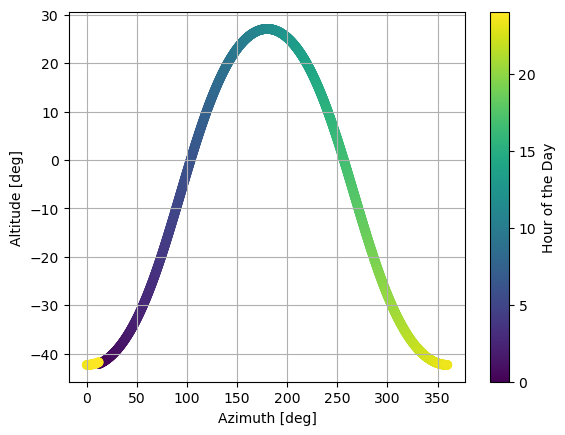

In [33]:
start_date = '2023-03-01 00:00:00'
end_date = '2023-03-01 23:59:59'
date_range = pd.date_range(start=start_date, end=end_date, freq="min")
sun_pos = np.zeros([len(date_range), 2])
sun_vec = np.zeros([len(date_range), 3])
fig, ax = plt.subplots()
for i, date in enumerate(date_range):
    az, alt = solar_position(date, lat, lng)
    sun_pos[i,:] = az, alt
    sun_vec[i,:] = solar_angles_to_vector((az), (alt))

hours_of_day = date_range.hour + date_range.minute / 60
scat = ax.scatter(*np.rad2deg(sun_pos).T, c = hours_of_day)
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label("Hour of the Day")
ax.set(xlabel = "Azimuth [deg]",
       ylabel = "Altitude [deg]",
       aspect = "auto")
ax.grid()
plt.show()

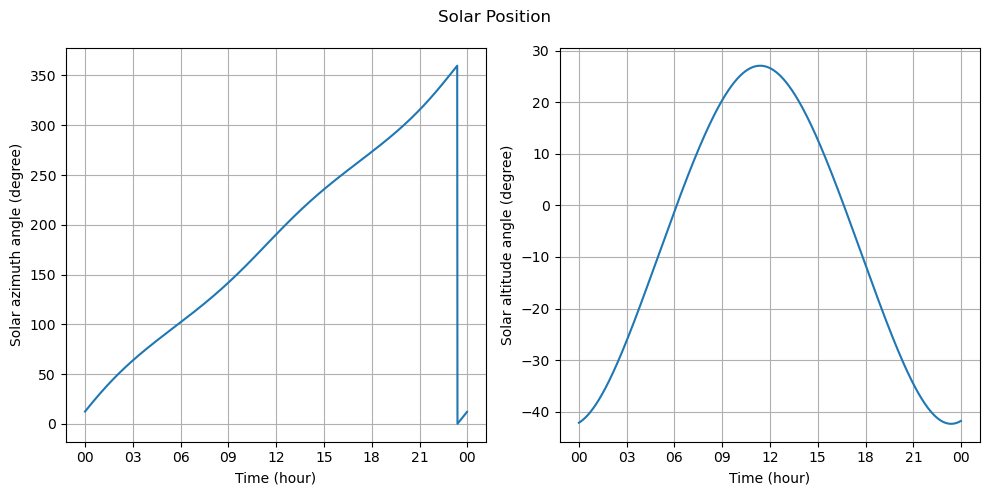

In [34]:
import matplotlib.dates as mdates

# Plots for solar zenith and solar azimuth angles
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Solar Position')

# plot for solar zenith angle
axs[0].plot(date_range, np.rad2deg(sun_pos[:,0]))
axs[0].set_ylabel('Solar azimuth angle (degree)')
axs[0].set_xlabel('Time (hour)')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# plot for solar azimuth angle
axs[1].plot(date_range,  np.rad2deg(sun_pos[:,1]))
axs[1].set_ylabel('Solar altitude angle (degree)')
axs[1].set_xlabel('Time (hour)')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

[ax.grid(True) for ax in axs.flatten()]
plt.tight_layout()


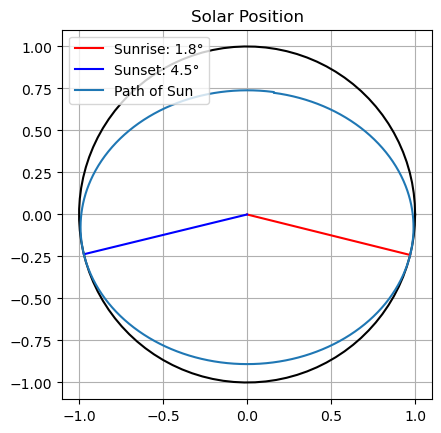

In [35]:
positive_indices = np.where(sun_pos[:,1] > 0)[0]

if positive_indices.size > 0:
    first_azimuth, last_azimuth = sun_pos[positive_indices[[0, -1]], 0]

# Create a unit circle
theta = np.linspace(0, 2 * np.pi, 100)
circle_coords = np.array([np.cos(theta), np.sin(theta)])
sunrise_vec = np.array([[0, np.sin(first_azimuth)], [0, np.cos(first_azimuth)]])

fig, ax = plt.subplots()
ax.plot(*circle_coords, 'k') # circle
ax.plot([0, np.sin(first_azimuth)], [0, np.cos(first_azimuth)], 'r', label=f'Sunrise: {(first_azimuth):.1f}°')
ax.plot([0, np.sin(last_azimuth)], [0, np.cos(last_azimuth)], 'b', label=f'Sunset: {(last_azimuth):.1f}°')
ax.plot(sun_vec[:,0], sun_vec[:,1], label = "Path of Sun")

ax.legend(loc = "upper left")
ax.set_aspect('equal', adjustable='box')
plt.title('Solar Position')
plt.grid()
plt.show()

This solar position can when be plotted on a map.

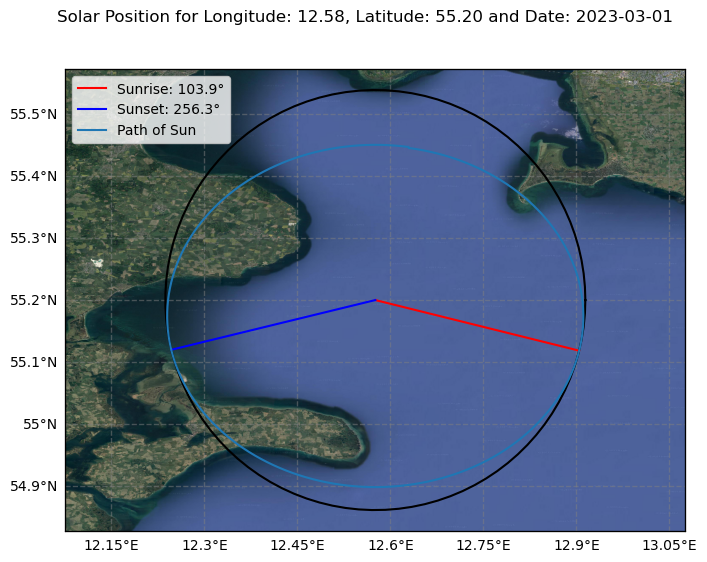

In [36]:
proj = ccrs.PlateCarree()
size = 0.5 # size of map radius
extent = [lng - size, lng + size, lat - size, lat + size]# Specify the map extent (latitude and longitude bounds)

fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(8, 6))
ax.set_extent(extent, crs=proj)
imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 12) # 16
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle(f"Solar Position for Longitude: {lng:.2f}, Latitude: {lat:.2f} and Date: " + start_date[:10])
ax2 = add_solar_axis(fig, ax)

ax2.plot(*circle_coords, 'k') # circle
ax2.plot([0, np.sin(first_azimuth)], [0, np.cos(first_azimuth)], 'r', label=f'Sunrise: {np.rad2deg(first_azimuth):.1f}°')
ax2.plot([0, np.sin(last_azimuth)], [0, np.cos(last_azimuth)], 'b', label=f'Sunset: {np.rad2deg(last_azimuth):.1f}°')
ax2.plot(sun_vec[:,0], sun_vec[:,1], label = "Path of Sun")
ax2.legend(loc = "upper left")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()